## Scale Magnitude Transform for genre/rythmic pattern classification


In [2]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import mirdata
import librosa
import stm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from rhythmic_features import feature as f
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ballroom


In [3]:
ballroom_dataset = mirdata.initialize("ballroom")
# ballroom_dataset.download()
ballroom_dataset.validate()

100%|██████████| 698/698 [00:09<00:00, 76.12it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'tracks': {}}, {'tracks': {}})

In [9]:
features = []
labels = []
for _, track in tqdm(ballroom_dataset.load_tracks().items()):
    y, sr = librosa.load(track.audio_path, sr=None)
    stm_mean = stm.compute_stm(oss_autocorrelation=y, sr=sr, target_sr=8000, mel_flag=False)

    # note that for this dataset, the number of coefs has been set to 170, as reported in the paper
    features.append(stm_mean[:170])
    if "rumba" in track.genre:
        labels.append("rumba")
    else:
        labels.append(track.genre)

encoded_labels = LabelEncoder().fit_transform(labels)

  0%|          | 0/698 [00:00<?, ?it/s]

100%|██████████| 698/698 [00:39<00:00, 17.67it/s]


Mean CV Accuracy: 0.8008595988538681


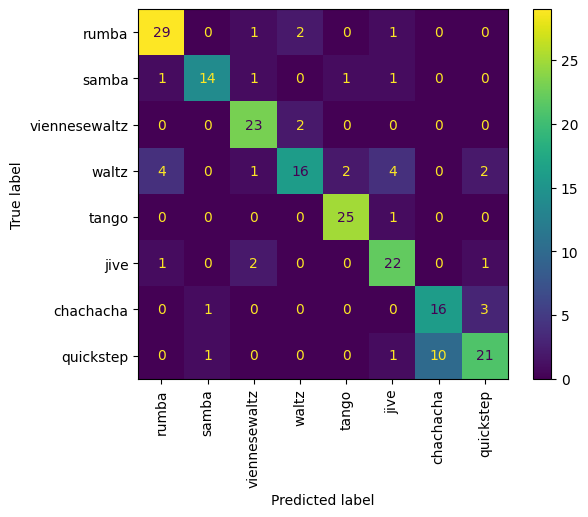

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnc = RadiusNeighborsClassifier(metric="cosine", radius=20)

loo = LeaveOneOut()
# k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")

print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(metric="cosine").fit(X=x_train, y=y_train)
# rnc = RadiusNeighborsClassifier(metric="cosine", radius=10).fit(X=x_train, y=y_train)

ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()

## GridSearch CV on Ballroom


In [ ]:
# Define a grid of parameters to search over
param_grid = {
    "n_mels": [50, 75, 100],  # Example values for n_mels
    "auto_cor_lag_seconds": [5, 8, 13],  # Example values for auto_cor_lag_seconds
    "stm_coefs": [i for i in range(30, 400, 30)],
}

best_score = -1
best_params = None

# Iterate over all combinations of parameters
for n_mels in param_grid["n_mels"]:
    for auto_cor_lag_seconds in param_grid["auto_cor_lag_seconds"]:
        for stm_coefs in param_grid["stm_coefs"]:
            print("n_mels:", n_mels, "auto_cor_lag_seconds:", auto_cor_lag_seconds, "stm_coefs:", stm_coefs)
            # Compute features with current parameters
            features = []
            labels = []
            for _, track in tqdm(ballroom_dataset.load_tracks().items()):
                y, sr = librosa.load(track.audio_path, sr=8000)
                features.append(
                    stm.compute_stm(
                        y=y,
                        sr=sr,
                        win_size=160,
                        hop=80,
                        n_mels=n_mels,
                        auto_cor_lag_seconds=auto_cor_lag_seconds,
                    )[:stm_coefs]
                )
                labels.append(track.genre)

            # Encode labels
            encoded_labels = LabelEncoder().fit_transform(labels)

            # Initialize and evaluate the classifier
            knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
            loo = LeaveOneOut()
            cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
            mean_cv_score = cv_scores.mean()
            print("Mean CV Accuracy:", mean_cv_score)

            # Update best score and parameters if needed
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {"n_mels": n_mels, "auto_cor_lag_seconds": auto_cor_lag_seconds}

# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Mean CV Accuracy:", best_score)

## Greek/Cretan Dances


In [6]:
cretan_dances_data_path = Path("../datasets/CretanDances")

features = []
labels = []

for subfolder in cretan_dances_data_path.iterdir():
    if subfolder.is_dir():
        label = subfolder.name
        print(label)
        for audio_file in subfolder.glob("*.wav"):
            y, sr = librosa.load(audio_file, sr=None)
            stm_mean = stm.compute_stm(oss_autocorrelation=y, sr=sr, target_sr=8000, mel_flag=False)
            features.append(stm_mean[:90])

            # note that for this dataset, the number of coefs has been set to 30, as reported in the paper
            labels.append(label)

encoded_labels = LabelEncoder().fit_transform(labels)

pentozalis
syrtos
sousta
maleviziotis
kalamatianos
kontilies


Mean CV Accuracy: 0.4972067039106145


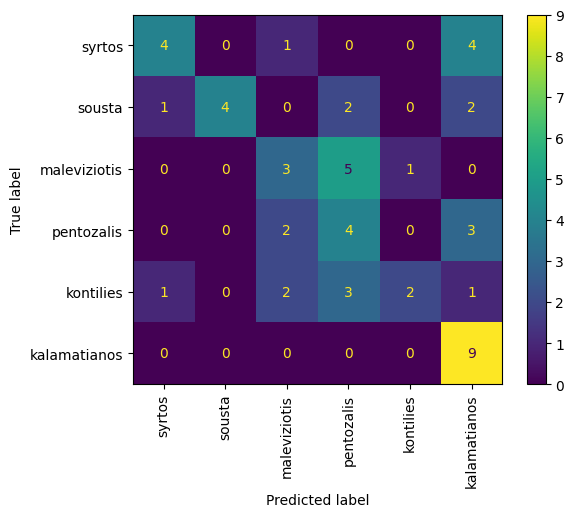

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

loo = LeaveOneOut()
# k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()

## GridSearch CV on GreekDances


In [ ]:
cretan_dances_data_path = Path("../datasets/CretanDances")

# Define a grid of parameters to search over
param_grid = {
    "n_mels": [50, 75, 100],  # Example values for n_mels
    "auto_cor_lag_seconds": [5, 8, 13],  # Example values for auto_cor_lag_seconds
    "stm_coefs": [i for i in range(30, 400, 30)],
}

best_score = -1
best_params = None

# Iterate over all combinations of parameters
for n_mels in param_grid["n_mels"]:
    for auto_cor_lag_seconds in param_grid["auto_cor_lag_seconds"]:
        for stm_coefs in param_grid["stm_coefs"]:
            print("n_mels:", n_mels, "auto_cor_lag_seconds:", auto_cor_lag_seconds, "stm_coefs:", stm_coefs)
            # Compute features with current parameters
            features = []
            labels = []
            for subfolder in cretan_dances_data_path.iterdir():
                if subfolder.is_dir():
                    label = subfolder.name
                    print(label)
                    for audio_file in subfolder.glob("*.wav"):
                        y, sr = librosa.load(audio_file, sr=8000)
                        features.append(
                            stm.compute_stm(
                                y=y,
                                sr=sr,
                                win_size=160,
                                hop=80,
                                n_mels=n_mels,
                                auto_cor_lag_seconds=auto_cor_lag_seconds,
                            )[:stm_coefs]
                        )
                        labels.append(label)

            # Encode labels
            encoded_labels = LabelEncoder().fit_transform(labels)

            # Initialize and evaluate the classifier
            knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
            loo = LeaveOneOut()
            cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
            mean_cv_score = cv_scores.mean()
            print("Mean CV Accuracy:", mean_cv_score)

            # Update best score and parameters if needed
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {"n_mels": n_mels, "auto_cor_lag_seconds": auto_cor_lag_seconds}

# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Mean CV Accuracy:", best_score)